In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv("./data/K-Data.csv")

C:\Users\paopa\AppData\Local\Temp\ipykernel_2368\2728384747.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/K-Data.csv")


In [3]:
df.head()

,m,s,e,u,grat_orientation,grat_contrast,grat_spat_freq,grat_phase,response,smoothed_response,region,unit_type,response_type,invariance,fit_quality,c_inv_ts
0,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.010000,0,0.013316,0.010386,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55
1,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.010000,90,0.013333,0.013067,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55
2,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.010000,180,0.009592,0.009712,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55
3,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.010000,270,0.007634,0.007415,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55
4,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.024022,0,0.003597,0.003837,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55


### Get the 5 dimensional array manually

Proven that the pandas code in the section after this does exactly the same thing but a lot more efficient

In [79]:
# v1 = df.query("region == 'V1'")
# m = v1.m.unique()[2]
# v1 = v1[v1.m == m] # take for all mice later
# v1 = v1.copy()  # to prevent warning
# v1["mouse_unit"] = v1["m"] + "_" + v1["u"].astype(str)
# print(len(v1))
# v1 = v1.groupby(["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase"]).sum().reset_index()
# v1 = v1[["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase", "response"]]

# orientations = sorted(v1.grat_orientation.unique())  # sort is in ascending
# contrasts = sorted(v1.grat_contrast.unique())
# spatial_frequencies = sorted(v1.grat_spat_freq.unique())
# phases = sorted(v1.grat_phase.unique())
# units = sorted(v1.mouse_unit.unique())

# tuncurv = np.empty((len(units), len(orientations), len(contrasts), len(spatial_frequencies), len(phases))).tolist()
# print(len(orientations) * len(contrasts) * len(spatial_frequencies) * len(phases) * len(units))
# print(len(units))
# print(len(orientations))
# print(len(contrasts))
# print(len(spatial_frequencies))
# print(len(phases))


# # MOST INEFFICIENT CODE EVER - run and save to pickle
# for i, u in tqdm(enumerate(units)):
#     for j, o in enumerate(orientations):
#         for k, c in enumerate(contrasts):
#             for l, s in enumerate(spatial_frequencies):
#                 for m, p in enumerate(phases):
#                     res = v1.query(f"mouse_unit == '{u}'").query(
#                         f"grat_orientation == {o}").query(
#                         f"grat_contrast == {c}").query(
#                         f"grat_spat_freq == {s}").query(
#                         f"grat_phase == {p}")["response"].to_list()
#                     if len(res) == 0:
#                         tuncurv[i][j][k][l][m] = 0
#                         print("not found", u, o, c, s, p)
#                     else:
#                         tuncurv[i][j][k][l][m] = res[0]


# # print(res)

In [80]:
# import pickle

# with open('data/tuncurv_v1_all_units.pickle', 'wb') as f:
#     pickle.dump(tuncurv, f)

In [81]:
import pickle

with open('data/tuncurv.pickle', 'rb') as f:
    tuncurv = pickle.load(f)

tuncurv = np.array(tuncurv)

### Reduce to 2 dimensions (Contrast and Orientation)

In [82]:
def print_tuning_curve(data_array, neuron_num):
    tuncurv_orien_contr = np.mean(np.mean(data_array, axis=4), axis=3)

    some_neuron = tuncurv_orien_contr.transpose((0, 2, 1))[neuron_num]

    plt.imshow(some_neuron, cmap='viridis')
    plt.colorbar()
    plt.show()

    for c in some_neuron:
        plt.plot(c)

    plt.show()

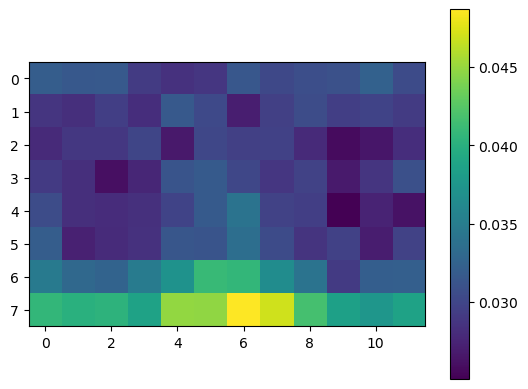

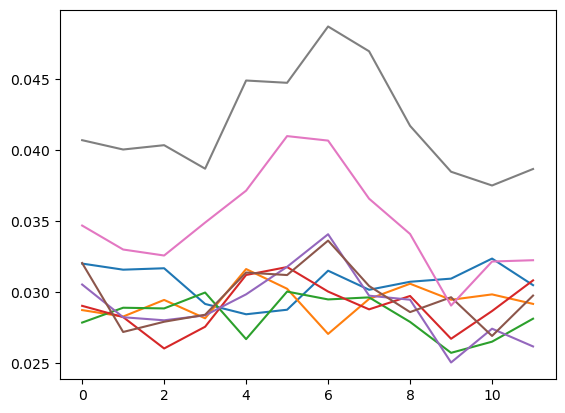

In [84]:
print_tuning_curve(tuncurv, 15)

## Pandas pipeline For 5 dimensions

0it [00:00, ?it/s]

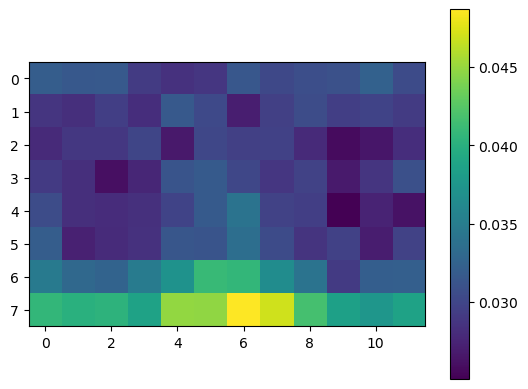

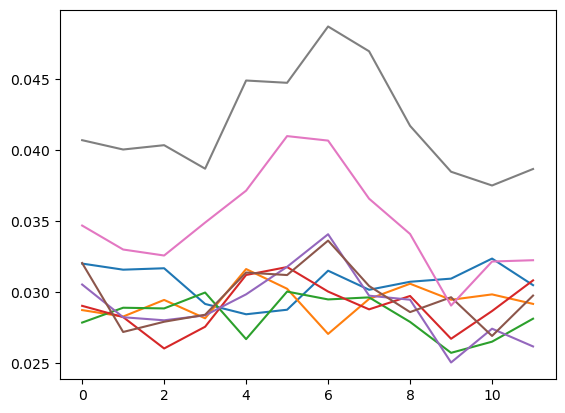

In [86]:
v1 = df.query("region == 'V1'")
m = v1.m.unique()[2]
v1 = v1[v1.m == m] # take for all mice later
v1 = v1.copy()  # to prevent warning
v1["mouse_unit"] = v1["m"] + "_" + v1["u"].astype(str)
v1 = v1.groupby(["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase"]).sum().reset_index()
v1 = v1[["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase", "response"]]

unique_units = v1['mouse_unit'].unique()
unique_orientation = v1['grat_orientation'].unique()
unique_contrast = v1['grat_contrast'].unique()
unique_spat_freq = v1['grat_spat_freq'].unique()
unique_phase = v1['grat_phase'].unique()

shape = (len(unique_units), len(unique_orientation), len(unique_contrast), len(unique_spat_freq), len(unique_phase))
result_array = np.full(shape, np.nan)

# Iterate through the DataFrame and fill the array
for index, row in tqdm(v1.iterrows()):
    u_index = np.where(unique_units == row['mouse_unit'])[0][0]
    orientation_index = np.where(unique_orientation == row['grat_orientation'])[0][0]
    contrast_index = np.where(unique_contrast == row['grat_contrast'])[0][0]
    spat_freq_index = np.where(unique_spat_freq == row['grat_spat_freq'])[0][0]
    phase_index = np.where(unique_phase == row['grat_phase'])[0][0]
    result_array[u_index, orientation_index, contrast_index, spat_freq_index, phase_index] = row['response']

print_tuning_curve(result_array, 15)

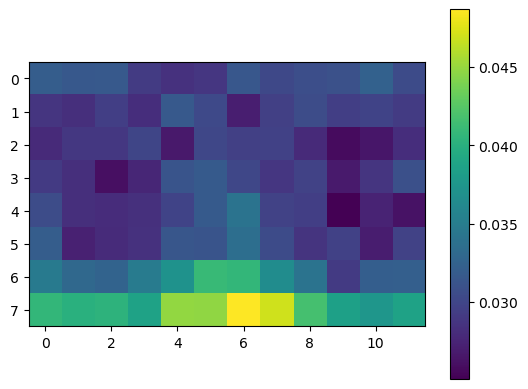

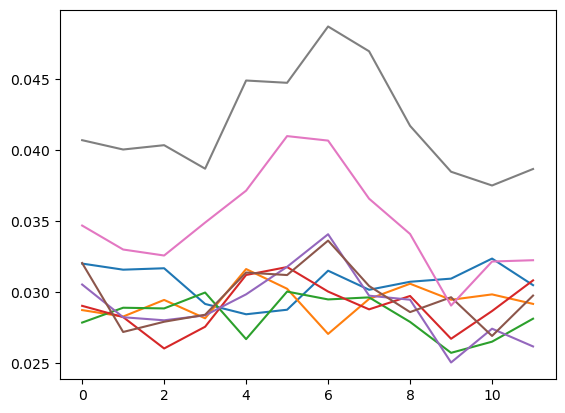

In [77]:
v1 = df.query("region == 'V1'")
m = v1.m.unique()[2]
v1 = v1[v1.m == m] # take for all mice later
v1 = v1.copy()  # to prevent warning
v1["mouse_unit"] = v1["m"] + "_" + v1["u"].astype(str)
v1 = v1.groupby(["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase"]).sum().reset_index()
v1 = v1[["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase", "response"]]

v1 = v1.groupby(['mouse_unit', 'grat_contrast', 'grat_orientation'], as_index=False).mean()
v1 = v1[["mouse_unit", "grat_orientation", "grat_contrast", "response"]]

unique_units = v1['mouse_unit'].unique()
unique_orientation = v1['grat_orientation'].unique()
unique_contrast = v1['grat_contrast'].unique()

# Create a 3D numpy array filled with NaN values
shape = (len(unique_units), len(unique_orientation), len(unique_contrast))
result_array = np.full(shape, np.nan)

# Iterate through the DataFrame and fill the array
for index, row in v1.iterrows():
    u_index = np.where(unique_units == row['mouse_unit'])[0][0]
    orientation_index = np.where(unique_orientation == row['grat_orientation'])[0][0]
    contrast_index = np.where(unique_contrast == row['grat_contrast'])[0][0]
    
    result_array[u_index, orientation_index, contrast_index] = row['response']


some_neuron = result_array.transpose((0, 2, 1))[15]
plt.imshow(some_neuron, cmap='viridis')
plt.colorbar()
plt.show()

for c in some_neuron:
    plt.plot(c)

plt.show()

### From 5 dimensions to preferred spatial freq and phase

In [11]:
v1 = df.query("region == 'V1'")
m = v1.m.unique()[2]
v1 = v1[v1.m == m] # take for all mice later
v1 = v1.copy()  # to prevent warning
v1["mouse_unit"] = v1["m"] + "_" + v1["u"].astype(str)
v1 = v1.groupby(["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase"]).sum().reset_index()
v1 = v1[["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase", "response"]]

unique_units = v1['mouse_unit'].unique()
unique_orientation = v1['grat_orientation'].unique()
unique_contrast = v1['grat_contrast'].unique()
unique_spat_freq = v1['grat_spat_freq'].unique()
unique_phase = v1['grat_phase'].unique()

shape = (len(unique_units), len(unique_orientation), len(unique_contrast), len(unique_spat_freq), len(unique_phase))
result_array = np.full(shape, np.nan)

# Iterate through the DataFrame and fill the array
for index, row in tqdm(v1.iterrows()):
    u_index = np.where(unique_units == row['mouse_unit'])[0][0]
    orientation_index = np.where(unique_orientation == row['grat_orientation'])[0][0]
    contrast_index = np.where(unique_contrast == row['grat_contrast'])[0][0]
    spat_freq_index = np.where(unique_spat_freq == row['grat_spat_freq'])[0][0]
    phase_index = np.where(unique_phase == row['grat_phase'])[0][0]
    result_array[u_index, orientation_index, contrast_index, spat_freq_index, phase_index] = row['response']

0it [00:00, ?it/s]

In [61]:
# For each neuron, find the index of preferred spacial freq and phase
result_array_list = result_array.transpose((0, 2, 1, 3, 4)).tolist()

preferred_freq_phase = []

for unit in result_array_list:
    max_response = 0
    freq_idx = 0
    phase_idx = 0
    for orient in unit[-1]: # Take max contrast
        for i, freq in enumerate(orient):
            for j, phase in enumerate(freq):
                if phase > max_response:
                    max_response = phase
                    freq_idx = i
                    phase_idx = j

    preferred_freq_phase.append([freq_idx, phase_idx])

reduced_array = np.empty((len(unique_units), len(unique_contrast), len(unique_orientation))).tolist()
i = 0
for unit, freq_phase_idx in zip(result_array_list, preferred_freq_phase):
    for j, con in enumerate(unit):
        for k, orient in enumerate(con):
            reduced_array[i][j][k] = orient[freq_phase_idx[0]][freq_phase_idx[1]]
    i += 1
reduced_array = np.array(reduced_array)

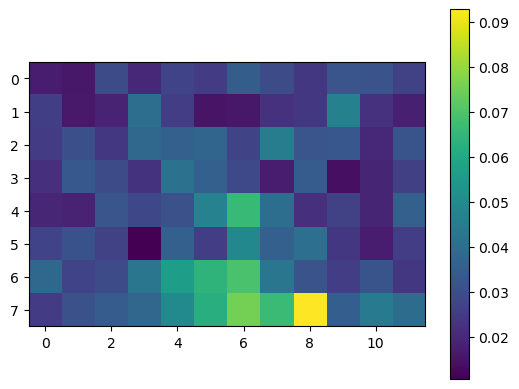

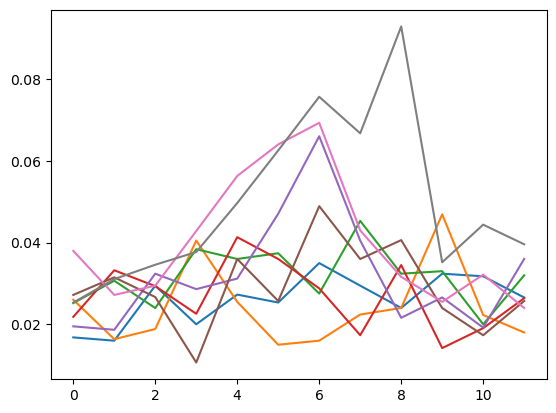

In [78]:
some_neuron = reduced_array[15]

plt.imshow(some_neuron, cmap='viridis')
plt.colorbar()
plt.show()

for c in some_neuron:
    plt.plot(c)

plt.show()

In [43]:
result_array_list.shape

array([0.       , 0.0432773, 0.103411 , 0.186966 , 0.303066 , 0.464386 ,
       0.68854  , 1.       ])

## Legacy code

In [13]:
# import mouse_utils as mu

In [14]:
# from scipy.ndimage.filters import gaussian_filter1d

In [15]:
# # J_array = [0.69, 0.64, 0., -0.29]
# # P_array = [-2.21, -2.21, -0.8, -0.8]
# # w_array = [3.46, 3.46, 3.46, 3.46]

# # J_array = [-5.1707, -0.0277,  0.9482,  0.1585]
# # P_array = [-6.1361, -1.9772,  0.8548,  1.2384]
# # w_array = [0.3990, 3.6245, 4.1893, 3.6955]

# J_array = [ 1.1768, -0.3358,  0.6635, -0.6340]
# P_array = [-0.1462, -2.3469, -2.3378, -1.1891]
# w_array = [4.2706, 3.4293, 3.4367, 3.4650]

# model = mu.NeuroNN(J_array, P_array, w_array, 2000)

In [16]:
# preds, _ = model()

In [17]:
# preds_array = preds.detach().numpy()

In [18]:
# preds_array.shape

In [19]:
# # weighted_mean = np.sum(unique_orientation * preds_array[1500][7]) / np.sum(preds_array[1500][7])
# # print(weighted_mean)
# # shift = 90 - weighted_mean

# # indexes = [340, 500, 600, 750, 850]
# indexes = [500, 600, 800, 856]
# colors = ["salmon", "skyblue", "seagreen", "khaki", "mediumslateblue"]
# indexes = [550, 1951]
# colors = ["salmon", "skyblue"]
# x = unique_orientation - 90

# for i, color in zip(indexes, colors):
#     weighted_mean = np.sum(unique_orientation * preds_array[i][7]) / np.sum(preds_array[i][7])
#     # shift = 90 - weighted_mean
#     shift = int((90 - weighted_mean) % 15) - 5

#     # argmax = np.argmax(preds_array[i][7])
#     # shift = 5 - np.argmax(preds_array[i][7])
#     for j in range(8):
#         y = gaussian_filter1d(preds_array[i][j], sigma=0.01)
#         max_val = np.max(y)
#         min_val = np.min(y)
#         y_shifted = (np.roll(y, shift) - min_val) / (max_val - min_val)
#         # y_shifted = np.roll(y, shift) / max_val
#         # y_shifted = y / max_val
#         plt.plot(x, y_shifted, color=color)

# plt.title("Normalised And Centered Tuning Curves From Tuned Model")
# plt.xlabel("Orientation / Degrees")
# plt.ylabel("Normalised Response / Hz")
# red_patch = mpatches.Patch(color='salmon', label='Excitatory Neuron')
# blue_patch = mpatches.Patch(color='skyblue', label='Inhibitory Neuron')
# plt.legend(handles=[red_patch, blue_patch], loc='upper right')
# plt.show()

In [20]:
# indexes = [10, 76]
# colors = ["salmon", "skyblue", "seagreen", "khaki"]
# x = unique_orientation - 90

# for i, color in zip(indexes, colors):
#     argmax = np.argmax(result_array[i][7])
#     shift = 6 - np.argmax(result_array[i][7])
#     for j in range(4,8):
#         y = gaussian_filter1d(result_array[i][j], sigma=0.1)
#         max_val = np.max(y)
#         min_val = np.min(y)
#         y_shifted = (np.roll(y, shift) - min_val) / (max_val - min_val)
#         # y_shifted = np.roll(y, shift) / max_val
#         plt.plot(x, y_shifted, color=color)

# plt.title("Normalised And Centered Tuning Curves From Actual Data")
# plt.xlabel("Orientation / Degrees")
# plt.ylabel("Normalised Response / Hz")
# red_patch = mpatches.Patch(color='salmon', label='Excitatory Neuron')
# blue_patch = mpatches.Patch(color='skyblue', label='Inhibitory Neuron')
# plt.legend(handles=[red_patch, blue_patch])
# plt.show()

In [21]:
# result_array.shape

In [22]:
# result_array_con = result_array.transpose((0, 2, 1))
# preds_array_con = preds_array.transpose((0, 2, 1))

In [23]:
# preds_array_con.shape

In [24]:
# # indexes = [300, 488, 699, 966]
# indexes = [550, 1951]
# # indexes = [500, 600, 800, 856]
# colors = ["salmon", "skyblue", "seagreen", "khaki", "mediumslateblue"]

# for i, color in zip(indexes, colors):
#     for j in range(12):
#         y = preds_array_con[i][j]
#         max_val = max(y)
#         min_val = min(y)
#         plt.plot(unique_contrast, (y - min_val) / (max_val - min_val), color=color)
#         # plt.plot(unique_contrast, y)

# plt.title("Normalised And Centered Tuning Curves From Tuned Model")
# plt.xlabel("Contrast")
# plt.ylabel("Normalised Response / Hz")
# red_patch = mpatches.Patch(color='salmon', label='Excitatory Neuron')
# blue_patch = mpatches.Patch(color='skyblue', label='Inhibitory Neuron')
# plt.legend(handles=[red_patch, blue_patch])
# plt.show()

In [25]:
# indexes = [10, 77]
# colors = ["salmon", "skyblue", "seagreen", "khaki"]

# for i, color in zip(indexes, colors):
#     for j in range(12):
#         y = result_array_con[i][j]
#         max_val = max(y)
#         min_val = min(y)
#         plt.plot(unique_contrast, (y - min_val) / (max_val - min_val), color=color)

# plt.title("Normalised And Centered Tuning Curves From Actual Data")
# plt.xlabel("Contrast")
# plt.ylabel("Normalised Response / Hz")
# red_patch = mpatches.Patch(color='salmon', label='Excitatory Neuron')
# blue_patch = mpatches.Patch(color='skyblue', label='Inhibitory Neuron')
# plt.legend(handles=[red_patch, blue_patch])
# plt.show()

In [26]:
# one_res = []
# for i in range(2000):
#     one_res.append(preds_array[i][7][4])

In [27]:
# plt.plot(one_res)
# plt.title("Activity of the network")
# plt.xlabel("Neuron Index")
# plt.ylabel("Response / Hz")